# Introduction


Kindly make a copy(**File-> Save a copy in Drive**) of this notebook and rename it (xAutoML_2022_Interpretability_firstname_lastname.ipynb).



# Session objectives


*   What is Interpretable Machine Learning?


*   Understanding how to put Interpretable Machine Learning into action.

# Setup

In [1]:
!pip install -U scikit-learn
!pip uninstall scikit-learn
!pip install scikit-learn

T
Y
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scikit_learn-1.3.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/sklearn/*
Proceed (Y/n)? Y
  Successfully uninstalled scikit-learn-1.3.2
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)


In [3]:
# importing the core packages :)
import pandas as pd
import numpy as np
from scipy import stats
import time
from statistics import median
import os
import pickle
import scipy.stats
import requests



# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Creating train and test sets
from sklearn.model_selection import train_test_split



 # ML model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor



# Metric
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Interpretability
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

#
from collections import defaultdict
from typing import List, Tuple, Dict
import collections
import copy
import json

# for ignoring the warnings massages.
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# List of homeworks


Homeworks are added at the end of the notebook in the form of two questions that you must analyze and justify by writing the code and explaining your results.
1. Given an instance, explain the model prediction. Why would this customer (or would not) subscribe? - 2 points
2. Explain the impact of the following features on the model performance: 'age', 'balance', 'day',"duration", "loan", and "outcome". Support your explanation with figures and comment on these figures - 4 points

# Interpretable Machine Learning
What is Interpretable Machine Learning?


![](https://miro.medium.com/max/1400/0*IWLWbvl2xUJLD-va.png)
Image source: https://towardsdatascience.com/interpretable-machine-learning-1dec0f2f3e6b






In this practice session, we will discuss following topics:


*   Global Model-Agnostic Methods:
      > Partial Dependence Plot (PDP)

*   Local Model-Agnostic Methods:

      > Local Surrogate (LIME)

# Partially dependent plots
Partially dependent plots demonstrate how each feature in Dataset influences the model's predictions. PDPs help us to discover new insights regarding understanding how ML-pipeline works.
It is a model-agnostic method which means that it does not depend on the model type. To figure out how the PDP work, you may want to watch this video(https://youtu.be/21QAKe2PDkk).



## Data collection


In [4]:
# # downloading data source: https://github.com/njtierney/melb-housing-data/blob/master/data/housing.csv
## more info about the data : https://github.com/njtierney/melb-housing-data

housing_df=pd.read_csv("./housing.csv")

## Let's find out what data is all about!

In [5]:
# let's know some info about dataframe.
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   suburb          34857 non-null  object 
 1   rooms           34857 non-null  int64  
 2   type            34857 non-null  object 
 3   price           27247 non-null  float64
 4   method          34857 non-null  object 
 5   seller_g        34857 non-null  object 
 6   date            34857 non-null  object 
 7   distance        34856 non-null  float64
 8   postcode        34856 non-null  float64
 9   bedroom2        26640 non-null  float64
 10  bathroom        26631 non-null  float64
 11  car             26129 non-null  float64
 12  landsize        23047 non-null  float64
 13  building_area   13742 non-null  float64
 14  year_built      15551 non-null  float64
 15  council_area    34854 non-null  object 
 16  latitude        26881 non-null  float64
 17  longitude       26881 non-null 

In [6]:
housing_df.shape

(34857, 21)

In [7]:
housing_df.sample(10)

suburb  rooms type      price method       seller_g  \
17164         Mulgrave      3    h        NaN     SN         Biggin   
6762       Middle Park      2    u   700000.0     SP           Greg   
27397         Viewbank      4    h  1150000.0     VB          Miles   
28641         Essendon      2    u   525000.0     SA         Nelson   
14252  Bayswater North      4    h   825000.0     SP        Appleby   
3893            Elwood      3    u  1220000.0     SP       Chisholm   
6561       Maribyrnong      2    t   370000.0     PI         Nelson   
31000     Melton South      4    h   410000.0      S  hockingstuart   
16926    Fitzroy North      1    u   495000.0      S         Jellis   
11234          Fawkner      3    h   585000.0      S  hockingstuart   

             date  distance  postcode  bedroom2  ...  car  landsize  \
17164  2017-05-27      18.8    3170.0       NaN  ...  NaN       NaN   
6762   2016-04-16       4.1    3206.0       2.0  ...  1.0       0.0   
27397  2017-11-11       8.9    3084.0       4.0  ...  2.0       NaN   
28641  2017-11-25       7.5    3040.0       NaN  ...  NaN       NaN   
14252  2017-07-01      23.2    3153.0       NaN  ...  NaN       NaN   
3893   2016-09-17       7.7    3184.0       NaN  ...  NaN       NaN   
6561   2016-06-12       8.7    3032.0       NaN  ...  NaN       NaN   
31000  2018-02-03      29.8    3338.0       4.0  ...  2.0     583.0   
16926  2017-05-27       3.6    3068.0       1.0  ...  1.0       0.0   
11234  2016-08-06      12.4    3060.0       0.0  ...  1.0     605.0   

       building_area  year_built                council_area  latitude  \
17164            NaN         NaN         Monash City Council       NaN   
6762            67.0      1970.0   Port Phillip City Council -37.85560   
27397            NaN         NaN        Banyule City Council -37.73970   
28641            NaN         NaN  Moonee Valley City Council       NaN   
14252            NaN         NaN      Maroondah City Council       NaN   
3893             NaN         NaN   Port Phillip City Council       NaN   
6561             NaN         NaN    Maribyrnong City Council       NaN   
31000          136.0      1975.0         Melton City Council -37.71357   
16926            NaN         NaN       Moreland City Council -37.78737   
11234          103.0      1960.0           Hume City Council -37.69850   

       longitude                 region_name property_count  yr_qtr  
17164        NaN  South-Eastern Metropolitan         7113.0  2017.2  
6762   144.96690       Southern Metropolitan         2019.0  2016.2  
27397  145.08910        Eastern Metropolitan         2698.0  2017.4  
28641        NaN        Western Metropolitan         9264.0  2017.4  
14252        NaN        Eastern Metropolitan         3598.0  2017.3  
3893         NaN       Southern Metropolitan         8989.0  2016.3  
6561         NaN        Western Metropolitan         4918.0  2016.2  
31000  144.57512            Western Victoria         4718.0  2018.1  
16926  144.98735       Northern Metropolitan         6244.0  2017.2  
11234  144.96150       Northern Metropolitan         5070.0  2016.3  

[10 rows x 21 columns]

In [8]:
# dropping rows with NaN values
housing_df=housing_df.dropna()

In [9]:
# check the shape after removing the NaN value
housing_df.shape

(8887, 21)

In [10]:
#Limmiting the features into 4 features. Feel free to change them and add more features
features = ['distance', 'landsize', 'building_area',"rooms"]

y = housing_df.price

X = housing_df[features]

In [11]:
# create train and test set and fit a GradientBoostingRegressor to dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 2021)
gbr_model = GradientBoostingRegressor(random_state=2021).fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
mae_score_gbr=mean_absolute_error(y_test,y_pred_gbr)

print(" mean_absolute_error for Gradient Boosting Regressor ",mae_score_gbr )


 mean_absolute_error for Gradient Boosting Regressor  257899.30758792118


## Partial Dependence Plot (PDP)



In [12]:
# Interpretability
# from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

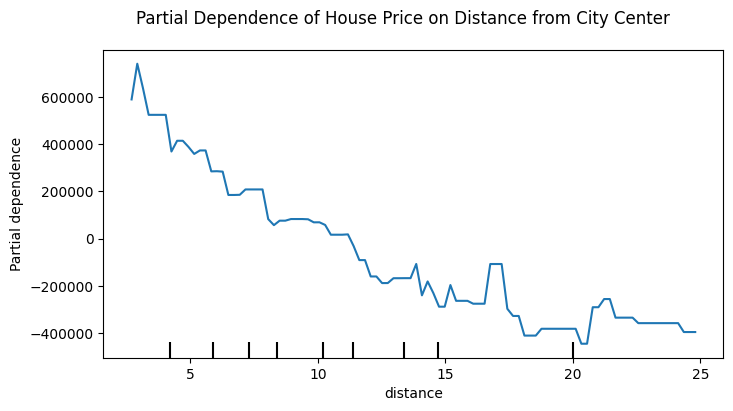

In [13]:
# use plot_partial_dependence to interpret the impact of distance on the price of the house!
# [start code here]

fig, ax = plt.subplots(figsize=(8, 4))
plt1 = PartialDependenceDisplay.from_estimator(gbr_model, X_train, features=['distance'], ax=ax)
plt1.figure_.suptitle("Partial Dependence of House Price on Distance from City Center")
plt1.figure_.subplots_adjust(wspace=0.3, hspace=0.3)

# [end code here]

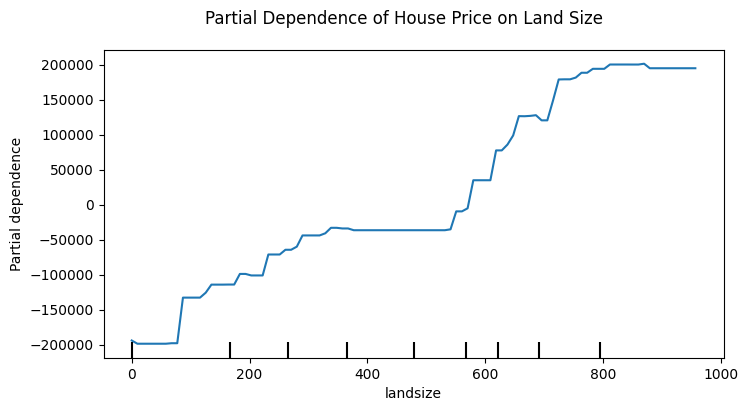

In [14]:
# use plot_partial_dependence to interpret the impact of land size on the price of the house!
# [start code here]

fig, ax = plt.subplots(figsize=(8, 4))
plt2 = PartialDependenceDisplay.from_estimator(gbr_model, X_train, features=['landsize'], ax=ax)
plt2.figure_.suptitle("Partial Dependence of House Price on Land Size")
plt2.figure_.subplots_adjust(wspace=0.3, hspace=0.3)

# [end code here]

Display the impact of two the features (rooms and landsize) on house's price.

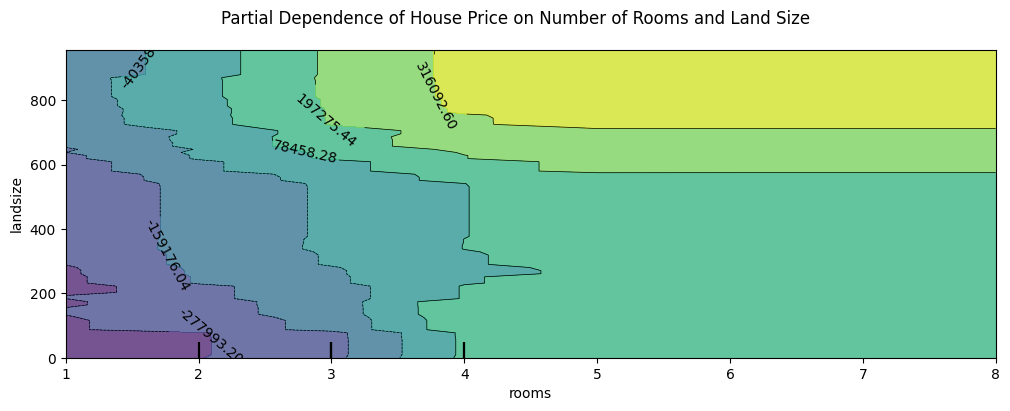

In [15]:
## Display the impact of two the features (rooms and landsize) on house's price.
# [start code here]

fig, ax = plt.subplots(figsize=(12, 4))
plt3 = PartialDependenceDisplay.from_estimator(gbr_model, X_train, features=[('rooms', 'landsize')], ax=ax)
plt3.figure_.suptitle("Partial Dependence of House Price on Number of Rooms and Land Size")
plt3.figure_.subplots_adjust(wspace=0.3, hspace=0.3)

# [end code here]

# Local Interpretable Model-agnostic Explanations  (LIME)
LIME is an explanation technique that explain an ML model locally around the prediction. For more details, you can read this paper(["Why Should I Trust You?": Explaining the Predictions of Any Classifier
](https://arxiv.org/abs/1602.04938)). Further, you can watch this video([LIME](https://youtu.be/hUnRCxnydCc))


In [16]:
# let us ckeck if we alreadly import the dataframe
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=38887cfbeabd1f2fada31caffd0872ce35eb072b420349ee9158d3542261deb4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [17]:
X_train.columns

Index(['distance', 'landsize', 'building_area', 'rooms'], dtype='object')

In [18]:
import lime
# as our data is tabular, we use lime_tabular
from lime import lime_tabular

In [20]:
# create a lime tabular explainer for our regression problem
# [start code here]

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression'
)

# [end code here]

In [21]:
# Please change the house index(instance_index) in order to see different interpretation
instance_index = 42
# [start code here]

exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index],
    predict_fn=gbr_model.predict
)

# [end code here]

In [22]:
# What does this result mean to you?
# a bar chart displaying the weights of how features influenced this prediction, and a table displaying the actual feature values
exp.show_in_notebook(show_table=True)

**Explanation:** The output from LIME provides a local interpretation of the model's prediction for a specific instance—in this case, the house at index 42 in your test dataset. Here's what the provided output tells us:
* **Predicted Value:** The model predicts the house's value to be approximately $170,472.91. This is the value that the model has estimated for the house based on the features provided.
* **Feature Contributions:**
    * `distance <= 6.40`: This feature has the most significant positive impact on the prediction. The house's relative closeness to the city center (3.10 units of distance, less than or equal to 6.40) increases the predicted value by about $721,276.61. This suggests that proximity to the city center is highly valued in the model.
    * `building_area <= 100.00`: The building area of the house (90.00, which is less than or equal to 100.00) positively influences the prediction, increasing the value by approximately $415,135.19. This indicates that the model finds a more significant building area to be a positive factor in house valuation.
    * `rooms <= 2.00`: The number of rooms (2.00, which is less than or equal to 2.00) also positively affects the house's predicted value, contributing an increase of about $265,375.88. This suggests that having at least two rooms is a positive factor, although it's not as strong a contributor as distance or building area.
    * `landsize <= 215.00`: The land size of the house (17.00, which is less than or equal to 215.00) contributes positively to the prediction by about $251,723.35. Even though the actual land size is small, according to the model, it still adds value to the house.
* **Feature values:** The table lists the actual values of the features for this particular house. These are the values that the model used to make its prediction.

In summary, the LIME explanation shows that being closer to the city center (distance) is the most significant factor in increasing the house's predicted value for this particular instance. The building area and the number of rooms also contribute positively but to a lesser extent. The land size has the slightest positive impact among the features listed.

# Homework
Given the Bank marketing dataset from the first lab, Kindly answer the following questions:

In [23]:
# downloading data source: https://datahub.io/machine-learning/bank-marketing/r/bank-marketing.csv
# Also If you want to know more about the data, please check this link (https://datahub.io/machine-learning/bank-marketing)
req = requests.get("https://datahub.io/machine-learning/bank-marketing/r/bank-marketing.csv")

url_content = req.content
csv_file = open('bank_marketing.csv', 'wb')
csv_file.write(url_content)
csv_file.close()
bank_marketing_df=pd.read_csv("./bank_marketing.csv")
bank_marketing_df.columns=['age','job', 'marital', 'education', 'default','balance', 'housing', 'loan', 'contact','day', 'month','duration','campaign','pdays','previous', 'outcome', 'class']

# change target label from 1,2 to 0,1
bank_marketing_df['class'] = (bank_marketing_df['class'] > 1).astype(int)


In [24]:
# we can change the column names based on the source (https://datahub.io/machine-learning/bank-marketing)

categorical_cloumns = list(bank_marketing_df.select_dtypes(include=['object']).columns)
categorical_cloumns

labelencoder = LabelEncoder()
for col in categorical_cloumns:
  bank_marketing_df[col]=labelencoder.fit_transform(bank_marketing_df[col])

# As feature for our ML model we just select 4 feature, feel free to change it and add more feature
features = ['age', 'balance', 'day',"duration", "loan","outcome"]
y=bank_marketing_df['class']
X=bank_marketing_df.drop('class',1)
X=X[features]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,y, test_size = 0.33, random_state = 2021)

gb_model = GradientBoostingClassifier(random_state=2021).fit(X_train_b, y_train_b)

## Given the following instance, explain the model prediction. Why this customer would (or would not) sunbscribe ? - 2 points

In [25]:
X_test_b.iloc[21]

age         44
balance      0
day         24
duration    81
loan         0
outcome      3
Name: 16836, dtype: int64

In [26]:
# Create a lime tabular explainer for our classification problem
explainer_b = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_b),
    feature_names=X_train_b.columns,
    class_names=['Not Subscribed', 'Subscribed'],
    mode='classification'
)

In [28]:
# Explain the prediction for the instance at index 21
instance_index_b = 21  # Change this index to explain different instances
exp_b = explainer_b.explain_instance(
    data_row=X_test_b.iloc[instance_index_b],
    predict_fn=gb_model.predict_proba
)

In [29]:
# Display the explanation
exp_b.show_in_notebook(show_table=True)

**Explanation:** Based on your LIME explanation output, the model predicts with a high probability (99%) that the customer will not subscribe to a term deposit. Here's a breakdown of the factors that contribute to this prediction:
1. **Duration:** The last contact with the customer is 81.00 seconds, less than or equal to 103.00 seconds. This is the most significant negative influence on the subscription likelihood, weighing 0.31. It suggests that shorter calls are associated with a lower subscription chance, indicating that the customer was not engaged enough to consider the offer seriously.
2. **Balance:** The customer's balance is 0.00, less than or equal to 72.00. This hurts the likelihood of subscribing, with a weight of 0.08. A low or zero balance might indicate a lower financial capacity or interest in investments like term deposits.
3. **Loan:** The customer does not have a loan (value 0.00), which surprisingly contributes negatively (weight 0.08) to the subscription prediction in this case. This could be an artifact of the model or suggest that in the context of other features, having no loan is not a strong enough positive indicator for this customer to subscribe.
4. **Age:** The customer's age is 44, which is between 39 and 48 years old. This feature has a slight positive weight (0.02), suggesting that customers in this age group are slightly more likely to subscribe than others, but in this case, it's not enough to sway the overall prediction.
5. **Day:** The contact day is the 24th, which is considered late in the month (day > 21.00) and has a slight positive weight (0.02). This could mean that contacts made later in the month have a slightly higher chance of leading to a subscription, although the impact is minimal here.
6. **Outcome:** The 'outcome' feature has a value of 3.00, which does not contribute significantly to the prediction (weight 0.00). This feature might represent the outcome of the previous campaign, and its lack of influence suggests that the previous outcome is not a deciding factor for this customer.

In conclusion, the short duration of the last call and the customer's zero balance are the most significant factors leading the model to predict that this customer is unlikely to subscribe to a term deposit. The absence of a loan, the customer's age, and the contact timing within the month have some influence but are not strong enough to counteract the effects of the other features. The model's prediction reflects a combination of these factors, with the most weight given to the call duration and balance.

## Explain the impact of the following features on the model performance: 'age', 'balance', 'day',"duration", "loan", and "outcome". - 4 points
Support your explanation with figures and comment on these figures. you need to explain how the feature impact on the prediction.

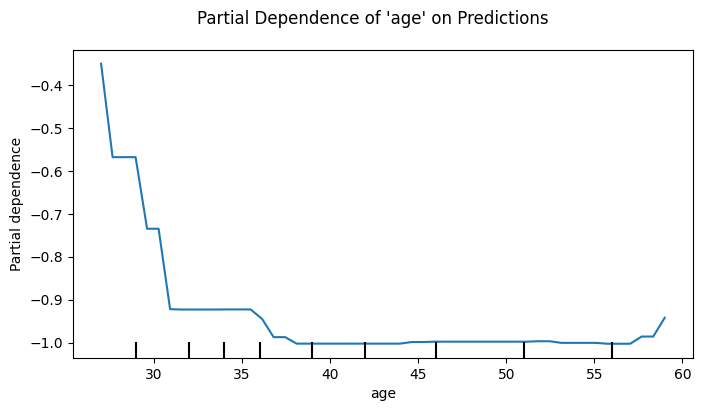

In [30]:
# Write your code for 'age'
fig, ax = plt.subplots(figsize=(8, 4))
age_display = PartialDependenceDisplay.from_estimator(
    gb_model, X_train_b, features=['age'], ax=ax, grid_resolution=50
)
age_display.figure_.suptitle("Partial Dependence of 'age' on Predictions")
age_display.figure_.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

**Explanation:** It shows how the probability of subscribing changes with the age of the customer. You might see trends like higher probabilities for younger and older age groups if they are more likely to subscribe.

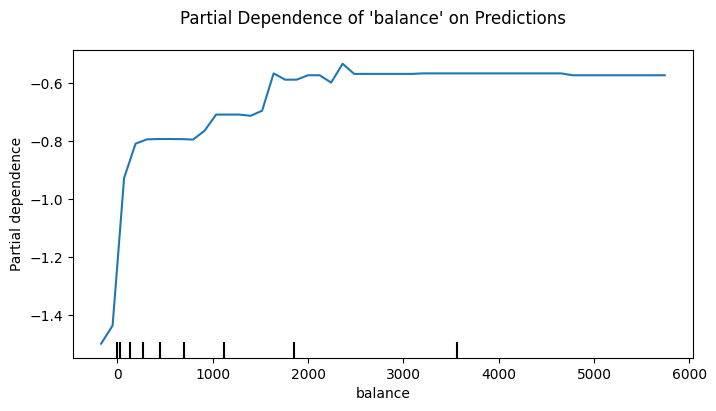

In [31]:
# Write your code for 'balance'
fig, ax = plt.subplots(figsize=(8, 4))
balance_display = PartialDependenceDisplay.from_estimator(
    gb_model, X_train_b, features=['balance'], ax=ax, grid_resolution=50
)
balance_display.figure_.suptitle("Partial Dependence of 'balance' on Predictions")
balance_display.figure_.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

**Explanation:** It illustrates if having a higher balance is associated with a higher likelihood of subscribing to the term deposit.

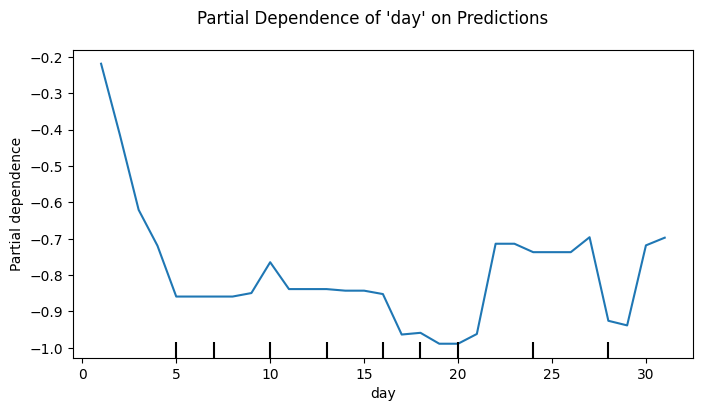

In [32]:
# Write your code for 'day'
fig, ax = plt.subplots(figsize=(8, 4))
day_display = PartialDependenceDisplay.from_estimator(
    gb_model, X_train_b, features=['day'], ax=ax, grid_resolution=50
)
day_display.figure_.suptitle("Partial Dependence of 'day' on Predictions")
day_display.figure_.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

**Explanation:** It reveals if there are certain days of the month when customers are more likely to subscribe.

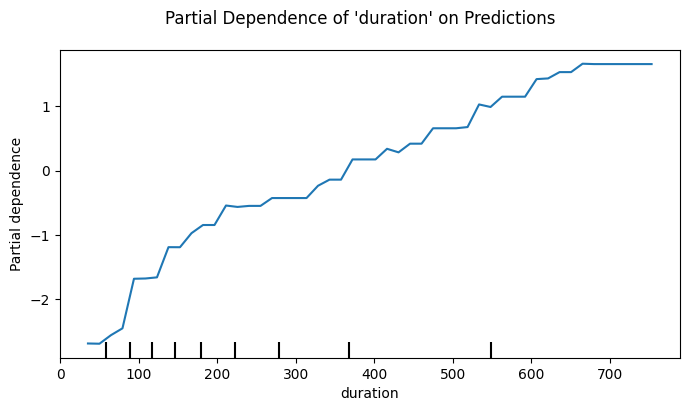

In [33]:
# Write your code for 'duration'
fig, ax = plt.subplots(figsize=(8, 4))
duration_display = PartialDependenceDisplay.from_estimator(
    gb_model, X_train_b, features=['duration'], ax=ax, grid_resolution=50
)
duration_display.figure_.suptitle("Partial Dependence of 'duration' on Predictions")
duration_display.figure_.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

**Explanation:** It is a very informative plot, as the duration of the last contact is often a strong predictor. Longer durations indicates a higher interest in the product.

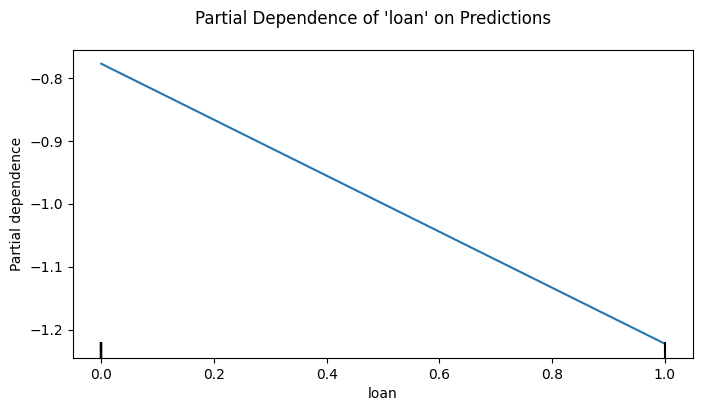

In [34]:
# Write your code for 'loan'
fig, ax = plt.subplots(figsize=(8, 4))
loan_display = PartialDependenceDisplay.from_estimator(
    gb_model, X_train_b, features=['loan'], ax=ax, grid_resolution=50
)
loan_display.figure_.suptitle("Partial Dependence of 'loan' on Predictions")
loan_display.figure_.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

**Explanation:** It shows if having a personal loan negatively impacts the likelihood of subscribing, which is often the case.

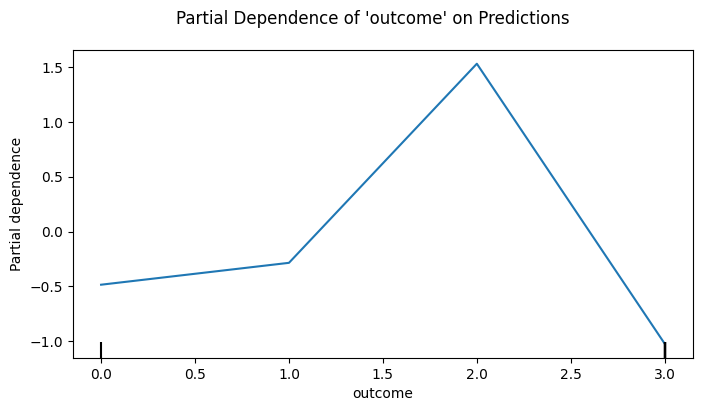

In [35]:
# Write your code for 'outcome'
fig, ax = plt.subplots(figsize=(8, 4))
outcome_display = PartialDependenceDisplay.from_estimator(
    gb_model, X_train_b, features=['outcome'], ax=ax, grid_resolution=50
)
outcome_display.figure_.suptitle("Partial Dependence of 'outcome' on Predictions")
outcome_display.figure_.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

**Explanation:** The 'outcome' feature represents the result of the previous marketing campaign. This plot shows if a successful previous outcome leads to a higher subscriber probability.

# Share your thoughts and provide us feedback regarding to this notebook.(Optional)


Write your feedback here:

# <font color='green'> Finished! </font>



